In [58]:
# Dependencies

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

import os

# Load the data
TEMP_FOLDER = os.path.join('..', 'TEMP')
files = os.listdir(TEMP_FOLDER) # list the files in the TEMP folder
# print(files) # print the files

# Penalties data table
###### FROM CSV ######
# p_path = 'penalty_summary_ALL_SEASONS.csv'
# penalties = pd.read_csv(os.path.join(TEMP_FOLDER, p_path))
## FROM DB FILE (penalty_summary table) ######


db_path = os.path.join('..','data', 'db', 'Combined_DB_v2.db')
conn = sqlite3.connect(db_path)
penalties = pd.read_sql_query("SELECT * FROM penalty_summary", conn)


penalties.head(10)

,game_id,Season,Period,Team,Player,Pen_Length,Penalty_Type,Time
0,2004-03-05-Air Force-Wayne State,2003,1st Period,Wayne State,Matt Boldt,2,Charging,2:13
1,2004-03-05-Air Force-Wayne State,2003,1st Period,Air Force,Brooks Turnquist,2,Cross-Checking,4:43
2,2004-03-05-Air Force-Wayne State,2003,1st Period,Wayne State,Mark Cannon,2,Cross-Checking,14:28
3,2004-03-05-Air Force-Wayne State,2003,2nd Period,Air Force,Brian Reese,2,Hooking,4:23
4,2004-03-05-Air Force-Wayne State,2003,2nd Period,Wayne State,Aaron Hundt,2,Interference,13:19
5,2004-03-05-Air Force-Wayne State,2003,2nd Period,Wayne State,Nate Higgins,2,CTH-HIGH STICKING,18:05
6,2004-03-05-Air Force-Wayne State,2003,2nd Period,Air Force,Brandon Merkosky,2,Roughing,18:50
7,2004-03-05-Air Force-Wayne State,2003,2nd Period,Wayne State,Aaron Hundt,2,Roughing,18:50
8,2004-03-05-Air Force-Wayne State,2003,3rd Period,Air Force,Steve Mead,2,Holding,5:32
9,2004-03-05-Air Force-Wayne State,2003,3rd Period,Wayne State,Greg Poupard,2,Holding,14:28


In [59]:
## Value counts of Penalty_Type
penalties['Penalty_Type'].value_counts()
# How many unique values are there in the 'Penalty_Type' column?
penalties['Penalty_Type'].nunique()

# Strip and lowercase the 'Penalty_Type' column
penalties['Penalty_Type'] = penalties['Penalty_Type'].str.strip().str.lower()

# make a list of the unique values in the 'Penalty_Type' column
penalty_types = penalties['Penalty_Type'].unique()

print(f'This many unique {len(penalty_types)}') # print len of penalty_types
# print(penalty_types)

This many unique 603


In [60]:
# Adjusting the function to handle non-string types gracefully
def flag_and_extract_cth(penalty_type):
    if pd.isnull(penalty_type) or not isinstance(penalty_type, str):
        return penalty_type, False  # Return as-is if not a string
    
    # Keywords for identifying CTH penalties
    cth_keywords = ["contact to the head", "cth"]
    # Check if the penalty type is related to CTH
    is_cth = any(keyword in penalty_type for keyword in cth_keywords)
    # Simplify CTH penalties to base type while preserving CTH information
    if is_cth:
        for keyword in cth_keywords:
            penalty_type = penalty_type.replace(keyword, '').strip()
        # Add "CTH" prefix to denote Contact to the Head penalties
        penalty_type = "CTH-" + penalty_type if penalty_type else "CTH"
    # Remove extra hyphens or spaces
    penalty_type = penalty_type.strip("-").strip()
    return penalty_type, is_cth

data = penalties.copy()
# Reapply the adjusted function
data['Standardized_Penalty_Type'] = data['Penalty_Type'].apply(lambda x: flag_and_extract_cth(x)[0])
data['Is_CTH'] = data['Penalty_Type'].apply(lambda x: flag_and_extract_cth(x)[1])

# Check the adjustments with a sample
data[['Penalty_Type', 'Standardized_Penalty_Type', 'Is_CTH']].sample(20)


,Penalty_Type,Standardized_Penalty_Type,Is_CTH
179956,cross-checking,cross-checking,False
18585,holding,holding,False
134819,slashing,slashing,False
179011,holding,holding,False
203215,hooking,hooking,False
145625,o-slashing,o-slashing,False
18349,roughing,roughing,False
181204,interference,interference,False
92654,cross-checking,cross-checking,False
163347,boarding,boarding,False


In [61]:
## Number of remaing unique values in the 'Standardized_Penalty_Type' column
data['Standardized_Penalty_Type'].nunique()

580

In [62]:
# Dictionary for standardizing common penalties
# This dictionary maps common variations or related terms to a standardized penalty name
standardization_dict = {
    "hooking": ["hooking", "obstruction hooking"],
    "tripping": ["tripping", "obstruction tripping"],
    "slashing": ["slashing", "obstruction slashing"],
    "holding": ["holding", "obstruction holding", "holding the stick"],
    "interference": ["interference", "goaltender interference", "obstruction interference", "ob-faceoff interference"],
    "cross-checking": ["cross-checking", "cth-cross-checking"],
    "high-sticking": ["high-sticking", "cth high sticking"],
    "elbowing": ["elbowing", "cth-elbowing"],
    "boarding": ["boarding"],
    "roughing": ["roughing", "cth-roughing", "roughing after the whistle", "roughing after whistle"],
    "fighting": ["fighting"],
    "delay of game": ["delay of game"],
    "unsportsmanlike conduct": ["unsportsmanlike conduct", "unsportsmanlike-diving", "diving"],
    "misconduct": ["misconduct", "game misconduct"],
    "game disqualification": ["game disqualification"],
    "charging": ["charging"],
    "kneeing": ["kneeing"],
    "checking from behind": ["checking from behind", "hitting from behind"],
}

# Function to further standardize penalty types based on the dictionary
def standardize_penalty_types(penalty_type):
    for standard, variations in standardization_dict.items():
        if penalty_type in variations or penalty_type == standard:
            return standard
    # If the penalty type does not match any known variations, return it as is
    return penalty_type

# Apply the standardization function to the 'Standardized_Penalty_Type' column
data['Standardized_Penalty_Type'] = data['Standardized_Penalty_Type'].apply(standardize_penalty_types)

# Let's check the unique standardized penalty types to see the results
standardized_unique_penalties = data['Standardized_Penalty_Type'].unique()
# Exclude NaN values from the unique penalties before sorting
standardized_unique_penalties_nonan = [ptype for ptype in standardized_unique_penalties if isinstance(ptype, str)]

# Sort and display the unique standardized penalty types, excluding NaNs
sorted_standardized_unique_penalties = sorted(standardized_unique_penalties_nonan)

print(f'This many unique penalties {len(sorted_standardized_unique_penalties)}') # print the number of unique penalties
# sorted_standardized_unique_penalties[:50]  # Show a sorted sample of the results


This many unique penalties 566


In [63]:
# Function to remove "CTH" prefixes and clean penalty types for rows flagged with contact to the head
def clean_cth_penalty_types(row):
    if row['Is_CTH']:
        # Remove the "CTH" prefix and any following non-alphabetic characters (e.g., '-', '/')
        cleaned_type = row['Standardized_Penalty_Type'].replace("CTH", "")
        cleaned_type = ''.join(filter(str.isalpha, cleaned_type))
    else:
        # For non-CTH penalties, just use the existing standardized penalty type
        cleaned_type = row['Standardized_Penalty_Type']
    return cleaned_type

# Apply the cleaning function to each row
data['Cleaned_Penalty_Type'] = data.apply(clean_cth_penalty_types, axis=1)

# Adjust the function to handle None values and non-string entries properly
def clean_misc_entries(penalty_type):
    if isinstance(penalty_type, str):
        if penalty_type.isalpha() or penalty_type in standardization_dict.keys():
            return penalty_type
    # Return None for entries that don't meet the criteria or are not strings
    return None

# Reapply the cleaning function with the adjustment
data['Cleaned_Penalty_Type'] = data['Cleaned_Penalty_Type'].apply(clean_misc_entries)

# Re-check the unique cleaned penalty types after further refinement
cleaned_unique_penalties = data['Cleaned_Penalty_Type'].dropna().unique()
sorted_cleaned_unique_penalties = sorted(cleaned_unique_penalties)
print(f'This many unique penalties {len(sorted_standardized_unique_penalties)}') # print the number of unique penalties
sorted_cleaned_unique_penalties[:50]  # Show a sorted sample of the results



This many unique penalties 566


['ag',
 'bc',
 'be',
 'bench',
 'benchgamemisconduct',
 'boarding',
 'bodychecking',
 'brokenstick',
 'carryingmorethanonestick',
 'cc',
 'ce',
 'charging',
 'checking',
 'checking from behind',
 'ci',
 'clipping',
 'co',
 'cr',
 'cross-checking',
 'crosschec',
 'crosschecking',
 'crosscheckingatw',
 'cs',
 'cw',
 'cx',
 'delay of game',
 'direct',
 'disqualification',
 'dive',
 'dl',
 'eh',
 'elbow',
 'elbowing',
 'elbowking',
 'em',
 'embelishment',
 'embellish',
 'embellishing',
 'embellishmen',
 'embellishment',
 'emblishment',
 'ex',
 'excessiveroughness',
 'facemask',
 'facemasking',
 'facewash',
 'facewashing',
 'ff',
 'fighting',
 'fn']

In [64]:
# value counts of the cleaned penalty types
data['Cleaned_Penalty_Type'].value_counts()

# value counts to csv table
# data['Cleaned_Penalty_Type'].value_counts().to_csv(f'{TEMP_FOLDER}/cleaned_penalty_types.csv')



# histogram of the cleaned penalty types
# data['Cleaned_Penalty_Type'].value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')

Cleaned_Penalty_Type
hooking                  28371
tripping                 27487
interference             27059
roughing                 24169
holding                  19545
                         ...  
gg                           1
unintentionalelbowing        1
crosscheckingatw             1
oe                           1
benchgamemisconduct          1
Name: count, Length: 168, dtype: int64

## Adding to the standard dictionary

In [65]:
standardization_dict["high-sticking"].extend([
    "highsticking", "highstick", "highstickingatw", 
    "indirecthighsticking", "indirecthighstick", 
    "incidentalhighsticking", "indhighstick", 
    "inadvertenthighsticking", "highstickingafterthewhi"
])

standardization_dict["elbowing"].extend([
    "elbowing", "indirectelbowing", "elbow", 
    "indelbowing", "elbowking", "incidentalelbowing", 
    "indelbow", "ielbowing", "indirectelbow", 
    "ielbow", "incelbowing", "incidentalelbow", 
    "unintentionalelbowing"
])

standardization_dict["cross-checking"].extend([
    "cross-checking", "crosschecking", "indirectcrosschecking", 
    "crosschec", "crosscheckingatw"
])

standardization_dict["roughing"].extend([
    "roughing", "indirectroughing", "roughingatw", 
    "excessiveroughness", "rough", "indirectrough", 
    "indroughing", "iroughing"
])




In [66]:
# Run the standardization function again to update the 'Cleaned_Penalty_Type' column
data['Cleaned_Penalty_Type'] = data['Cleaned_Penalty_Type'].apply(standardize_penalty_types)

# print the standard dictionary
print(standardization_dict)

{'hooking': ['hooking', 'obstruction hooking'], 'tripping': ['tripping', 'obstruction tripping'], 'slashing': ['slashing', 'obstruction slashing'], 'holding': ['holding', 'obstruction holding', 'holding the stick'], 'interference': ['interference', 'goaltender interference', 'obstruction interference', 'ob-faceoff interference'], 'cross-checking': ['cross-checking', 'cth-cross-checking', 'cross-checking', 'crosschecking', 'indirectcrosschecking', 'crosschec', 'crosscheckingatw'], 'high-sticking': ['high-sticking', 'cth high sticking', 'highsticking', 'highstick', 'highstickingatw', 'indirecthighsticking', 'indirecthighstick', 'incidentalhighsticking', 'indhighstick', 'inadvertenthighsticking', 'highstickingafterthewhi'], 'elbowing': ['elbowing', 'cth-elbowing', 'elbowing', 'indirectelbowing', 'elbow', 'indelbowing', 'elbowking', 'incidentalelbowing', 'indelbow', 'ielbowing', 'indirectelbow', 'ielbow', 'incelbowing', 'incidentalelbow', 'unintentionalelbowing'], 'boarding': ['boarding'],

In [67]:
# Look for the values from the standardization dictionary in the 'Cleaned_Penalty_Type' column and replace them with the key
for standard, variations in standardization_dict.items():
    data['Cleaned_Penalty_Type'].replace(variations, standard, inplace=True)

# Check the unique cleaned penalty types after the final standardization
final_cleaned_unique_penalties = data['Cleaned_Penalty_Type'].dropna().unique()
sorted_final_cleaned_unique_penalties = sorted(final_cleaned_unique_penalties)
print(f'This many unique penalties {len(sorted_final_cleaned_unique_penalties)}') # print the number of unique penalties

This many unique penalties 136


Cleaned_Penalty_Type
hooking                    28371
tripping                   27487
interference               27059
roughing                   24314
holding                    19545
slashing                   18829
cross-checking             14656
boarding                    9297
high-sticking               7964
misconduct                  7263
checking from behind        5709
elbowing                    5543
unsportsmanlike conduct     4465
charging                    3322
kneeing                     1159
delay of game               1100
embellishment                867
game disqualification        475
facemasking                  408
checking                     361
Name: count, dtype: int64

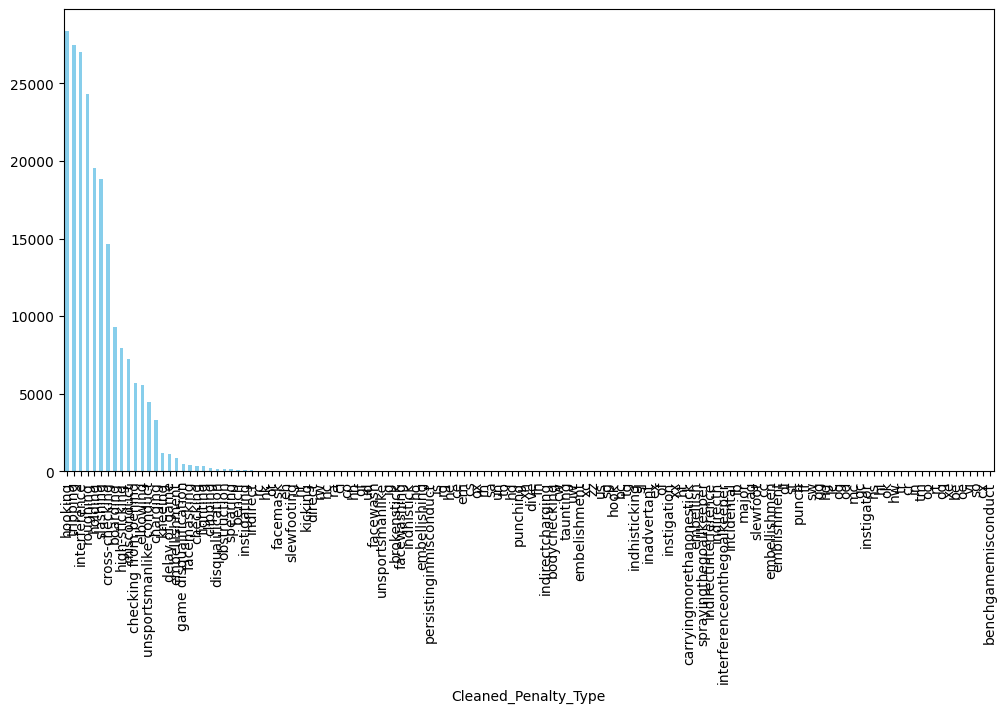

In [68]:
# value chart of the cleaned penalty types
data['Cleaned_Penalty_Type'].value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')

# To CSV for the cleaned penalty types
# data['Cleaned_Penalty_Type'].value_counts().to_csv(f'{TEMP_FOLDER}/cleaned_penalty_types.csv')

# to 20 penalty types
data['Cleaned_Penalty_Type'].value_counts().head(20)

In [69]:
## More dictionary adds

# roughing: 'checking', 'bodychecking'
# charging: boarding
# embellishment, embellishing, embelishment, embellish, embellishmen all together
# misconduct: game disqualification

standardization_dict["roughing"].extend([
    "checking", "bodychecking"
])

standardization_dict["charging"].extend([
    "boarding"
])

standardization_dict["unsportsmanlike conduct"].extend([
    "embellishment", "embellishing", "embelishment", "facemasking",
    "embellish", "embellishmen"
])

standardization_dict["misconduct"].extend([
    "game disqualification"
])

# Run the standardization function again to update the 'Cleaned_Penalty_Type' column
data['Cleaned_Penalty_Type'] = data['Cleaned_Penalty_Type'].apply(standardize_penalty_types)

# Look for the values from the standardization dictionary in the 'Cleaned_Penalty_Type' column and replace them with the key
for standard, variations in standardization_dict.items():
    data['Cleaned_Penalty_Type'].replace(variations, standard, inplace=True)

# Check the unique cleaned penalty types after the final standardization
final_cleaned_unique_penalties = data['Cleaned_Penalty_Type'].dropna().unique()
sorted_final_cleaned_unique_penalties = sorted(final_cleaned_unique_penalties)

# value chart of the cleaned penalty types
# data['Cleaned_Penalty_Type'].value_counts().plot(kind='bar', figsize=(12, 6), color='skyblue')

# value counts of the cleaned penalty types top 15
data['Cleaned_Penalty_Type'].value_counts().head(15)







Cleaned_Penalty_Type
hooking                    28371
tripping                   27487
interference               27059
roughing                   24677
holding                    19545
slashing                   18829
cross-checking             14656
charging                   12619
high-sticking               7964
misconduct                  7738
unsportsmanlike conduct     5748
checking from behind        5709
elbowing                    5543
kneeing                     1159
delay of game               1100
Name: count, dtype: int64

In [70]:
# print a pretty version of the dictionary that I can take to the next step
for key, value in standardization_dict.items():
    print(f'{key}: {value}')

# To CSV for the cleaned penalty types

hooking: ['hooking', 'obstruction hooking']
tripping: ['tripping', 'obstruction tripping']
slashing: ['slashing', 'obstruction slashing']
holding: ['holding', 'obstruction holding', 'holding the stick']
interference: ['interference', 'goaltender interference', 'obstruction interference', 'ob-faceoff interference']
cross-checking: ['cross-checking', 'cth-cross-checking', 'cross-checking', 'crosschecking', 'indirectcrosschecking', 'crosschec', 'crosscheckingatw']
high-sticking: ['high-sticking', 'cth high sticking', 'highsticking', 'highstick', 'highstickingatw', 'indirecthighsticking', 'indirecthighstick', 'incidentalhighsticking', 'indhighstick', 'inadvertenthighsticking', 'highstickingafterthewhi']
elbowing: ['elbowing', 'cth-elbowing', 'elbowing', 'indirectelbowing', 'elbow', 'indelbowing', 'elbowking', 'incidentalelbowing', 'indelbow', 'ielbowing', 'indirectelbow', 'ielbow', 'incelbowing', 'incidentalelbow', 'unintentionalelbowing']
boarding: ['boarding']
roughing: ['roughing', 'cth

In [71]:
# rough Catagories

# Obstruction penalties: hooking, tripping, holding, interference
# Physical penalties: roughing, boarding, charging, checking from behind, kneeing, cross-checking, high-sticking, elbowing
# Gamesmanship penalties: unsportsmanlike conduct, diving, embellishment, misconduct, game disqualification

# Create a new column 'Penalty_Category' to group the penalties into the three categories
penalty_category_dict = {
    "Obstruction": ["hooking", "tripping", "holding", "interference"],
    "Physical": ["roughing", "slashing", "cross-checking", "high-sticking", "elbowing"],
    "Dangerous Play": ["boarding", "charging", "checking from behind", "kneeing", "head contact"],
    "Gamesmanship": ["unsportsmanlike conduct", "diving", "embellishment", "misconduct", "game disqualification", "delay of game", "fighting"]
}

# Function to categorize the penalties based on the dictionary
def categorize_penalties(penalty_type):
    for category, penalties in penalty_category_dict.items():
        if penalty_type in penalties:
            return category
    # Return 'Other' for any penalties not in the main categories
    return "Other / Unknown"

# Apply the categorization function to create the 'Penalty_Category' column
data['Penalty_Category'] = data['Cleaned_Penalty_Type'].apply(categorize_penalties)

# Check the distribution of penalty categories
data['Penalty_Category'].value_counts()

Penalty_Category
Obstruction        102462
Physical            71669
Dangerous Play      19487
Other / Unknown     19414
Gamesmanship        14900
Name: count, dtype: int64


# # Plots and other exploration

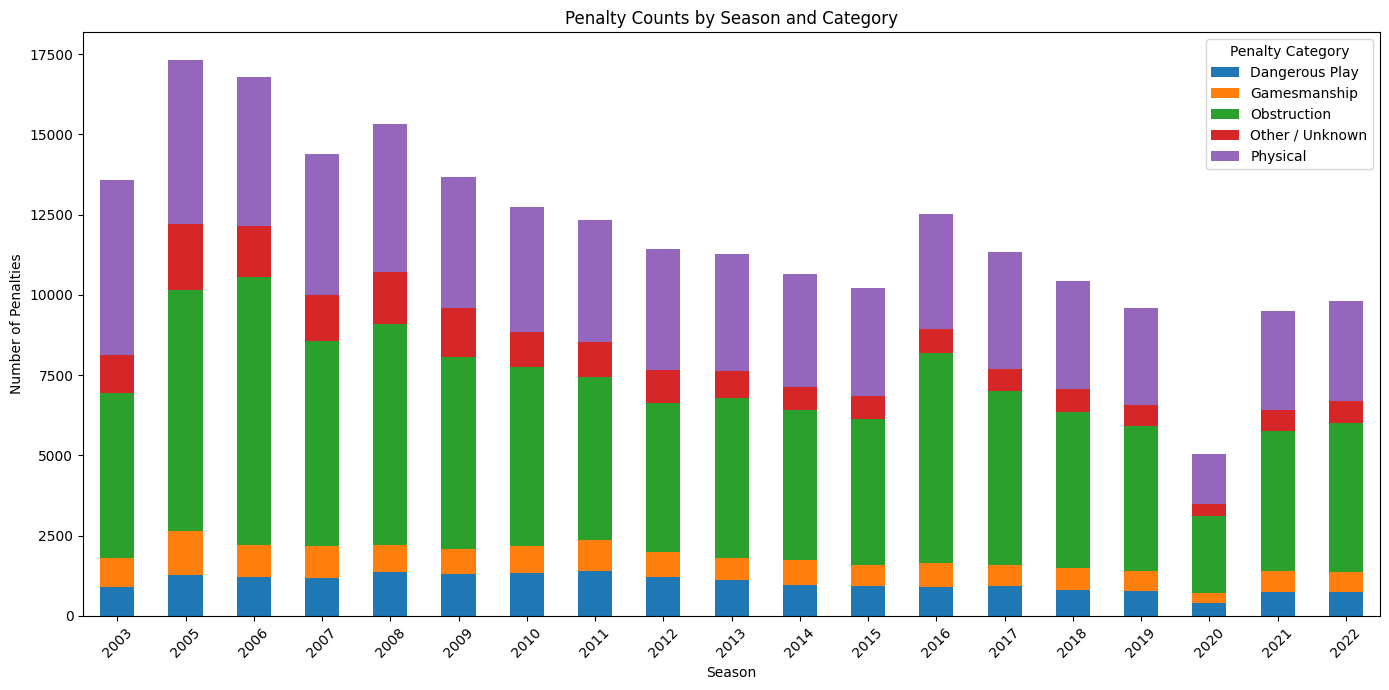

In [72]:
# How has the amount of penalties changed over the years? 
# Let's group the data by season and count the number of penalties each season.

# Group the data by 'Season' and 'Penalty_Category' and count the number of penalties
penalty_counts_by_season = data.groupby(['Season', 'Penalty_Category']).size().unstack()

# Plot the penalty counts by season for each category
penalty_counts_by_season.plot(kind='bar', stacked=True, figsize=(14, 7))
plt.title('Penalty Counts by Season and Category')
plt.xlabel('Season')
plt.ylabel('Number of Penalties')
plt.xticks(rotation=45)
plt.legend(title='Penalty Category')
plt.tight_layout()
plt.show()

In [74]:
data.head()

,game_id,Season,Period,Team,Player,Pen_Length,Penalty_Type,Time,Standardized_Penalty_Type,Is_CTH,Cleaned_Penalty_Type,Penalty_Category
0,2004-03-05-Air Force-Wayne State,2003,1st Period,Wayne State,Matt Boldt,2,charging,2:13,charging,False,charging,Dangerous Play
1,2004-03-05-Air Force-Wayne State,2003,1st Period,Air Force,Brooks Turnquist,2,cross-checking,4:43,cross-checking,False,cross-checking,Physical
2,2004-03-05-Air Force-Wayne State,2003,1st Period,Wayne State,Mark Cannon,2,cross-checking,14:28,cross-checking,False,cross-checking,Physical
3,2004-03-05-Air Force-Wayne State,2003,2nd Period,Air Force,Brian Reese,2,hooking,4:23,hooking,False,hooking,Obstruction
4,2004-03-05-Air Force-Wayne State,2003,2nd Period,Wayne State,Aaron Hundt,2,interference,13:19,interference,False,interference,Obstruction


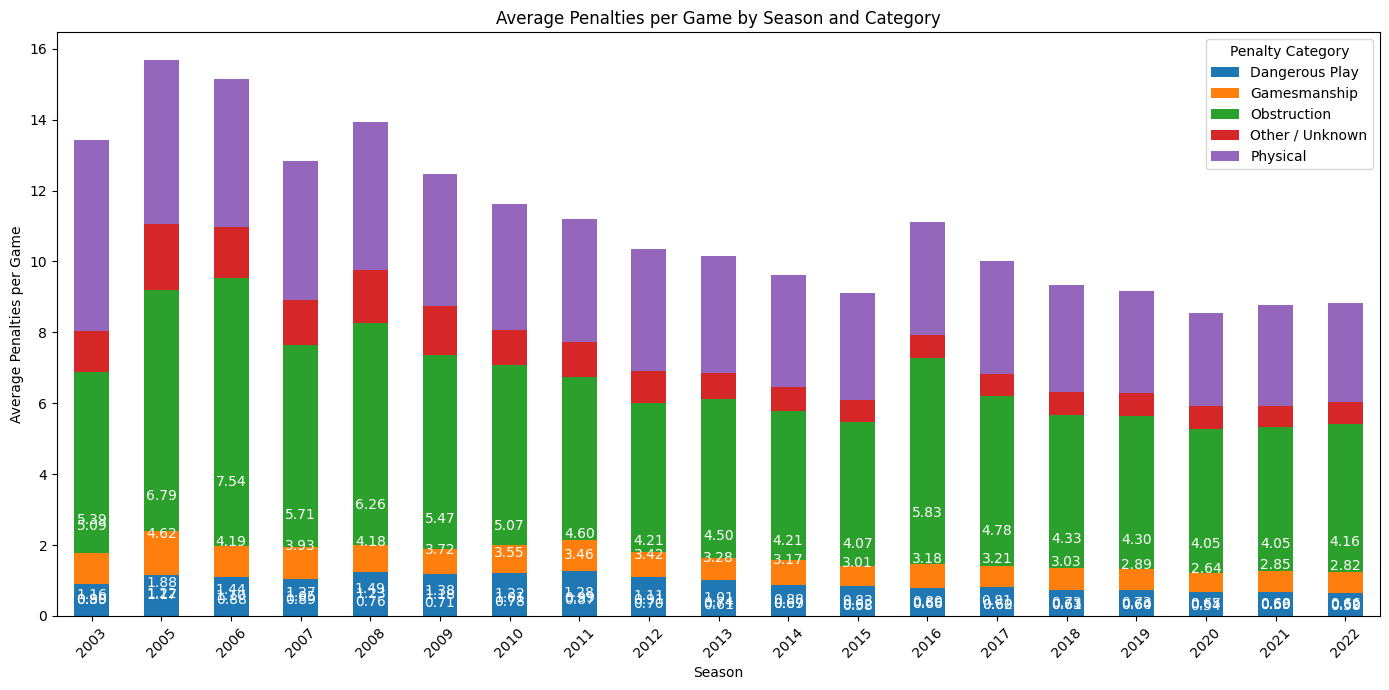

In [78]:
## Look at the average penalty minutes per game
## Same chart but devided by numbers of games in the season (unique Game_IDs)

# Group the data by 'Season' and 'Penalty_Category' and calculate the average penalty minutes per game
# Count of unique Game_IDs per season
games_per_season = data.groupby('Season')['game_id'].nunique()

# Calculate the average penalties called per game for each season
penalty_counts_by_season_per_game = penalty_counts_by_season.div(games_per_season, axis=0)
penalty_counts_by_season_per_game.plot(kind='bar', stacked=True, figsize=(14, 7))
# add the percentage to each bar segment
for p in penalty_counts_by_season_per_game.columns:
    for i, val in enumerate(penalty_counts_by_season_per_game[p]):
        plt.text(i, val/2, f'{val:.2f}', ha='center', va='center', color='white')

plt.title('Average Penalties per Game by Season and Category')
plt.xlabel('Season')
plt.ylabel('Average Penalties per Game')
plt.xticks(rotation=45)
plt.legend(title='Penalty Category')

plt.tight_layout()
plt.show()

## DONT LIKE THe FUZZY MATCH